# 데이터 전처리

In [3]:
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

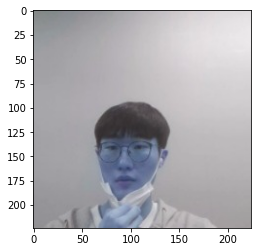

In [4]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/Folder/7.jpg'
img_bgr = cv2.imread(my_image_path) 
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()
# 이미지를 bgr로 불러서 원본 이미지를 훼손하지 않기 위해서 복사함

BGR 이미지 스머프가 된 모습이다

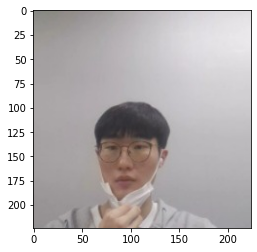

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()
# 이미지를 bgr에서 rgb로 색깔변환 

원래 RGB 이미지를 복원

# 모델 적용

In [6]:
detector_hog = dlib.get_frontal_face_detector() # 얼굴인식 detector를 불러옴

In [7]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb,1)
# 이미지에 detector를 사용해서 얼굴에 적용시킴

rectangles[[(55, 121) (129, 196)]]


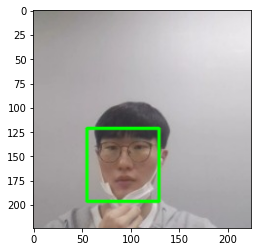

In [8]:
print(dlib_rects)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
# 사람 얼굴 인식한 곳을 박스로 이미지 출력

dlib_rect으로 얼굴을 인식해서 그 주의를 네모로 표현

In [9]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
# 얼굴의 이목구비를 인식하는 모델을 불러옴

In [10]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))
# 얼굴의 이목구비를 구분하는 landmarkds의 갯수를 출력

68


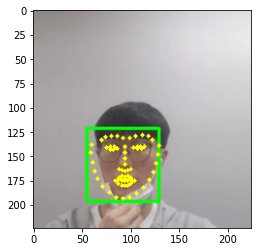

In [11]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0,255,255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
# 이전 cell에서 구한 landmarks를 실험 이미지에 적용

얼굴을 인식하는 landmark를 인식한 이미지 모습이다.

In [12]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33])
    x = landmark[33][0]
    y = landmark[33][1]
    w = h = dlib_rect.width()
    print('(x, y): (%d, %d)'%(x, y))
    print('(w, h): (%d, %d)'%(w, h))
    # x와 y에는 코 끝 데이터를 입력 w,h는 얼굴 인식 상자의 크기를 입력

(94, 165)
(x, y): (94, 165)
(w, h): (75, 75)


# 스티커 적용

In [13]:
sticker_path = os.getenv('HOME')+'/aiffel//camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
# 고양이 수염 스티커를 불러서 이를 상자 크기에 맞게 조정

(75, 75, 3)


In [14]:
refined_x = x - w//2
refined_y = y - h//2
print('(x, y): (%d, %d)'%(refined_x, refined_y))

(x, y): (57, 128)


In [15]:
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
    
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
    
print('(x, y): (%d, %d)'%(refined_x, refined_y))
# 범위가 벗어난 스티커를 조정

(x, y): (57, 128)


In [16]:
sticker_area = img_show[refined_y:refined_y + img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
# 스티커를 이미지에 적용

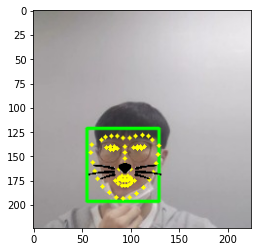

In [17]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

dlib_rect, landmark, 그리고 sticker까지 이미지에 적용한 기괴한 모습

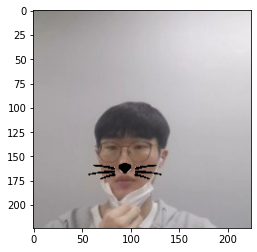

In [18]:
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()
# 스티커를 제외한 landmark와 dlib_rect을 지움

나름 고양이 수염이 잘 적용된 사진이다.

# 실험

In [44]:
def sticker(img_path):
    global x #외부에서 이미 선언한 변수를 함수로 불러오면 error 가 발생하므로 global 변수로 선언
    global y
    global w
    global h
    my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/Folder/'+ img_path
    img_bgr = cv2.imread(my_image_path)
    
    img_show = img_bgr.copy()
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    detector_hog = dlib.get_frontal_face_detector()
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1)
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
    
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
        
    for landmark in list_landmarks:
        for idx, point in enumerate(list_points):
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)
    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[33][0]
        y = landmark[33][1]
        w = dlib_rect.width()
        h = dlib_rect.width()
        
    sticker_path = os.getenv('HOME')+'/aiffel//camera_sticker/images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    
    refined_x = x-w//2
    refined_y = y-h//2
    
    if refined_x < 0:
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0
    
    sticker_area = img_bgr[refined_y: refined_y + img_sticker.shape[1], refined_x: refined_x + img_sticker.shape[1]]
    img_bgr[refined_y: refined_y + img_sticker.shape[1], refined_x: refined_x + img_sticker.shape[1]] = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)
    
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()
    # 앞에서 실행한 코드를 함수로 한 번에 정리해서 선언

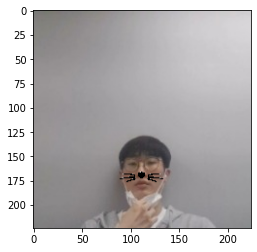

In [45]:
sticker('1.jpg')

얼굴을 최대한 작게해서 찍은 사진 dlib_rect도 작아져서 고양이 수염도 작아진 모습이다. 개인적으로 잘 적용되었다고 생각한다.

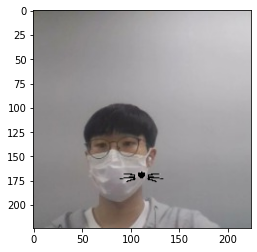

In [46]:
sticker('13.jpg')

마스크를 쓴 이미지를 적용했으나 실패

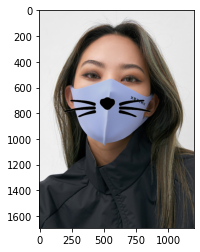

In [47]:
sticker('mask.jpg')

이전 실험과 같이 마스크를 써서 인식을 못하나 확인하기 위해 다시 실험, 하지만 나름 코끝을 잘 찾아서 수염이 잘 적용된 모습이다.

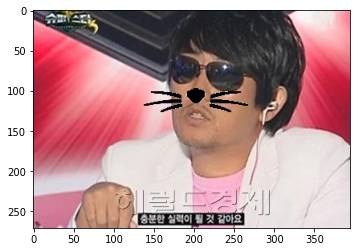

In [52]:
sticker('sunglass.jpg')

이번에 하관이 아닌 눈을 가렸을 때 인식을 제대로 하는지 실험. 결과는 성공적이다.

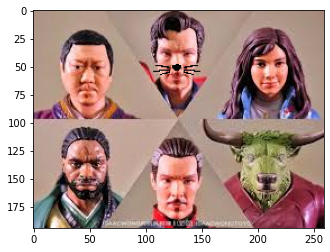

In [49]:
sticker('Doctor.jpeg')

다수의 인물이 있을 때 한 명만 인식하는 모습을 확인할 수 있음 소 친구는 몰라도 왜 나머지 4명은 인식을 못하는지 모르겠음

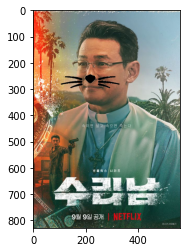

In [50]:
sticker('수리남.jpeg')

약간 옆을 보고 있는 황정민 배우님 사진이다. 포스터여서 인지 약간 만화 캐릭터 처럼 보인다.

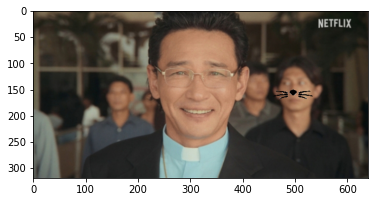

In [51]:
sticker('수리남2.jpg')

여기서도 가운데 있는 목사님이 아닌 뒤에 사람에 고양이 수염을 적용한 이미지다. 아직 여러 사람이 있을 때에는 코드에 보정이 필요한 모습이다.